## Train and test classificartion models

### Import libraries

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
from src.classification import *

### Define prediction classes variable (list)

In [62]:
pred_classes = ['Customers', 'Attrited']

### Load data

In [63]:
# Load the data
df = pd.read_csv("../data/BankChurners_CleanedMapped.csv", index_col="ClientID")
df.shape

(10127, 20)

In [64]:
column_names = list(df.columns)
#column_names

####  Prepare data
##### Split data to train/test, features/target

In [65]:
X_train, X_test, y_train, y_test = clean_split_data(df, column_names)

#####  Scale features

In [66]:
X_train, X_test = scale_classification_data(X_train, X_test)

### Logistic Regression Classifier

In [67]:
lrClassifier, report = fit_and_test_LR_classifier(X_train, X_test, y_train, y_test, pred_classes, ros=False)
print("\n", report)

Train:       0.9086532526848538
Test:        0.8928923988153998

               precision    recall  f1-score   support

   Customers       0.91      0.96      0.94      1700
    Attrited       0.74      0.52      0.61       326

    accuracy                           0.89      2026
   macro avg       0.83      0.74      0.77      2026
weighted avg       0.88      0.89      0.89      2026



#### LR Classifier w/ OverSampling

In [68]:
lrClassifier_ros, report = fit_and_test_LR_classifier(X_train, X_test, y_train, y_test, pred_classes, ros=True)
print("\n", report)

Train(ros):  0.8522794117647059
Train:       0.8503888408838415
Test:        0.8509378084896347

               precision    recall  f1-score   support

   Customers       0.96      0.86      0.91      1700
    Attrited       0.52      0.81      0.64       326

    accuracy                           0.85      2026
   macro avg       0.74      0.83      0.77      2026
weighted avg       0.89      0.85      0.86      2026



### Random Forest Classifier

In [69]:
rfClassifier, report = fit_and_test_RF_classifier(X_train, X_test, y_train, y_test, pred_classes)
print("\n", report)

Train:       0.9222318232316998
Test:        0.9146100691016782

               precision    recall  f1-score   support

   Customers       0.92      0.98      0.95      1700
    Attrited       0.86      0.56      0.68       326

    accuracy                           0.91      2026
   macro avg       0.89      0.77      0.81      2026
weighted avg       0.91      0.91      0.91      2026



#### RF Classifier w/ OverSampling

In [70]:
rfClassifier_ros, report = fit_and_test_RF_classifier(X_train, X_test, y_train, y_test, pred_classes, ros=True)
print("\n", report)

Train(ros):  0.9199264705882353
Train:       0.9065547463276139
Test:        0.8923988153998026

               precision    recall  f1-score   support

   Customers       0.97      0.90      0.93      1700
    Attrited       0.62      0.88      0.72       326

    accuracy                           0.89      2026
   macro avg       0.80      0.89      0.83      2026
weighted avg       0.92      0.89      0.90      2026



#### RF Classifier w/ balancing parameter

In [71]:
rfClassifier_rfb, report = fit_and_test_RF_classifier(X_train, X_test, y_train, y_test, pred_classes, rfb=True)
print("\n", report)

Train:       0.9233427971855327
Test:        0.9062191510365252

               precision    recall  f1-score   support

   Customers       0.97      0.91      0.94      1700
    Attrited       0.66      0.87      0.75       326

    accuracy                           0.91      2026
   macro avg       0.82      0.89      0.85      2026
weighted avg       0.92      0.91      0.91      2026



##### ... extract feature importance and trim feature list

In [72]:
threshold = 0.02
important_features = fit_RF_classifier_and_reduce_features(X_train, y_train, column_names, threshold)
display(important_features)

,Feature,Score
8,TotalProductNo,0.039031
9,MonthsInactive_Last12Months,0.023668
10,ContactNo_Last12Months,0.020910
12,TotalRevolvingBalance_CC,0.145714
14,TransactionAmount_ChangeQ4overQ1,0.053934
15,TotalTransactionAmount_Last12Months,0.186734
16,TotalTransactionCount_Last12Months,0.304737
17,TransactionCount_ChangeQ4overQ1,0.088953
18,AveCardUtilizationRatio,0.089375


In [73]:
column_names_important_features = ["Attrited"] + list(important_features["Feature"])
#column_names_important_features.remove("TotalTransactionCount_Last12Months")
display(column_names_important_features)

['Attrited',
 'TotalProductNo',
 'MonthsInactive_Last12Months',
 'ContactNo_Last12Months',
 'TotalRevolvingBalance_CC',
 'TransactionAmount_ChangeQ4overQ1',
 'TotalTransactionAmount_Last12Months',
 'TotalTransactionCount_Last12Months',
 'TransactionCount_ChangeQ4overQ1',
 'AveCardUtilizationRatio']

### Plot Important Features

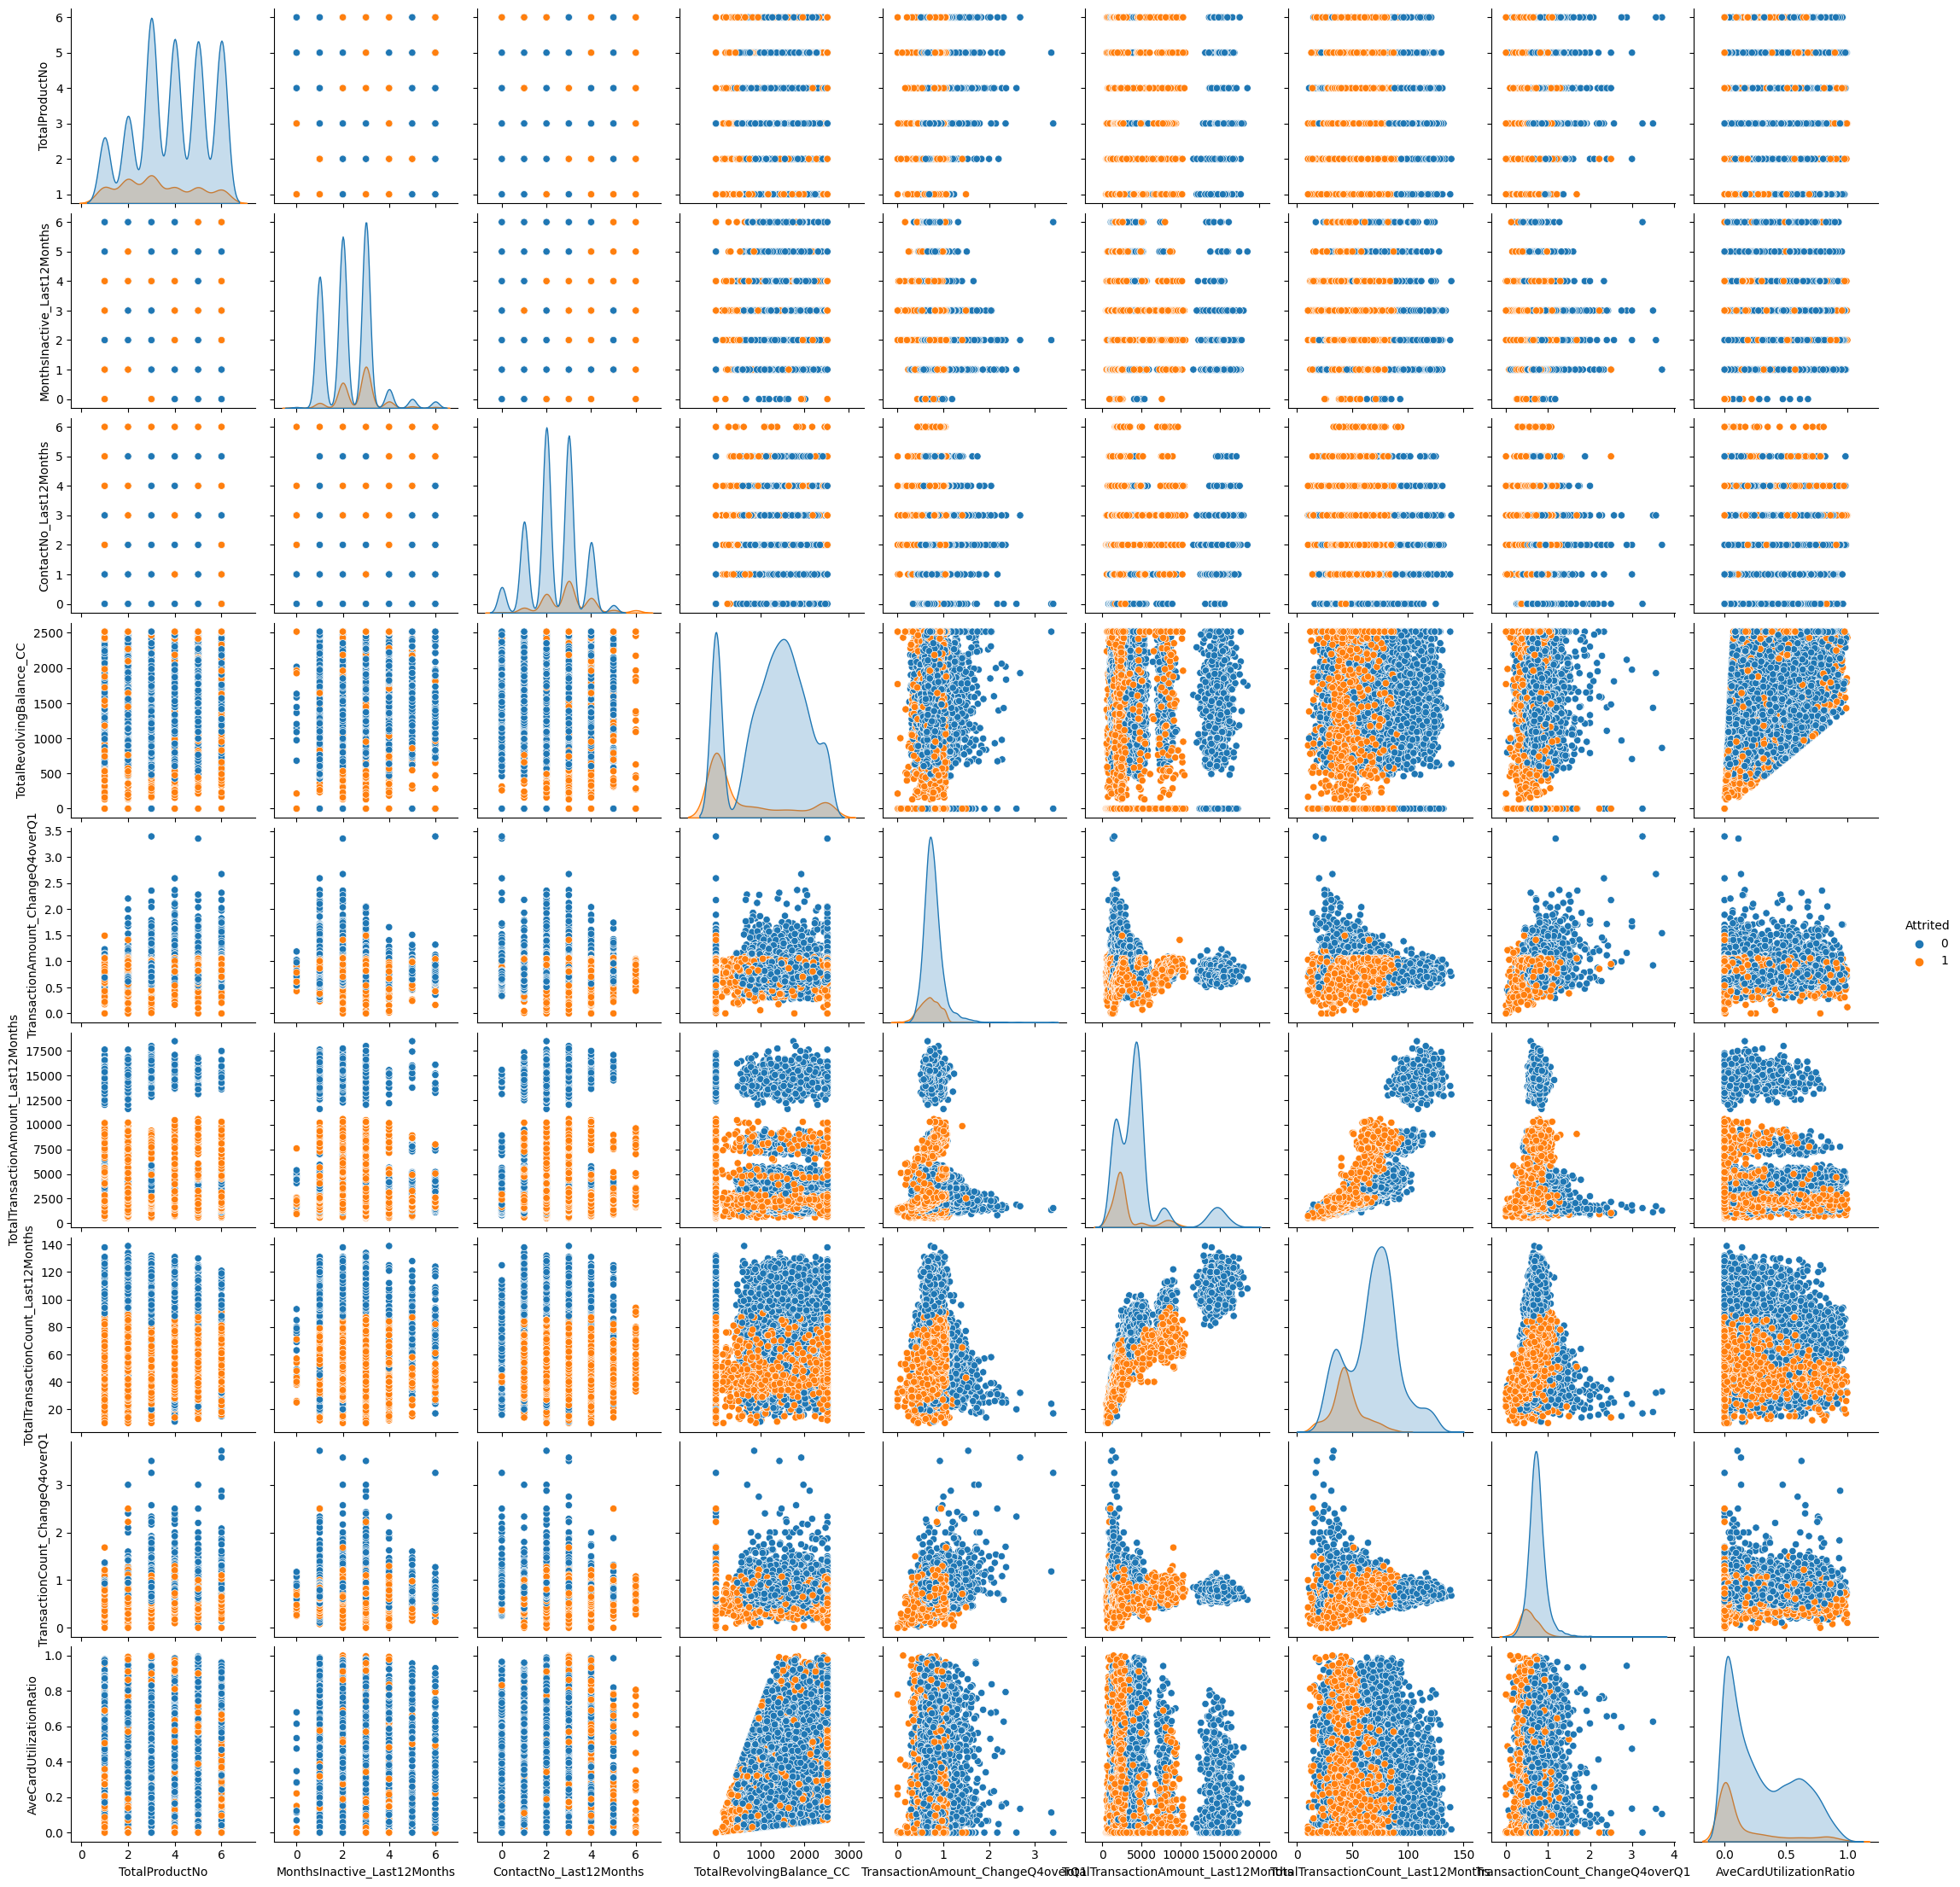

In [74]:
temp = df[column_names_important_features]
sns.pairplot(data=temp, hue="Attrited")
plt.show()

### Retrain Random Forest w/ only Important Features 

In [75]:
X_train, X_test, y_train, y_test = clean_split_data(df, column_names_important_features)
X_train, X_test = scale_classification_data(X_train, X_test)

In [76]:
rfClassifier_rf_rfb, report = fit_and_test_RF_classifier(X_train, X_test, y_train, y_test, pred_classes, rfb=True)
print("\n", report)

Train:       0.9300086409085299
Test:        0.9131293188548865

               precision    recall  f1-score   support

   Customers       0.98      0.92      0.95      1700
    Attrited       0.67      0.90      0.77       326

    accuracy                           0.91      2026
   macro avg       0.83      0.91      0.86      2026
weighted avg       0.93      0.91      0.92      2026



### Try RF with 5 features used in clustering

The results are less good compared to 9 features.

Classification model perfomrs better with 9 feautures.

In [77]:
column_names_important_features_2 = column_names_important_features[:]
to_remove = ["TotalProductNo", 
             "TransactionAmount_ChangeQ4overQ1", 
             "TotalTransactionCount_Last12Months", 
             "TransactionCount_ChangeQ4overQ1"]
for item in to_remove:
    column_names_important_features_2.remove(item)
display(column_names_important_features_2)

['Attrited',
 'MonthsInactive_Last12Months',
 'ContactNo_Last12Months',
 'TotalRevolvingBalance_CC',
 'TotalTransactionAmount_Last12Months',
 'AveCardUtilizationRatio']

In [78]:
X_train, X_test, y_train, y_test = clean_split_data(df, column_names_important_features_2)
X_train, X_test = scale_classification_data(X_train, X_test)

In [79]:
rfClassifier_rf5_rfb, report = fit_and_test_RF_classifier(X_train, X_test, y_train, y_test, pred_classes, rfb=True)
print("\n", report)

Train:       0.8802616960869029
Test:        0.8677196446199408

               precision    recall  f1-score   support

   Customers       0.96      0.88      0.92      1700
    Attrited       0.56      0.83      0.67       326

    accuracy                           0.87      2026
   macro avg       0.76      0.85      0.79      2026
weighted avg       0.90      0.87      0.88      2026

